In [66]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv
/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip


In [67]:
# Necessary imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import zipfile

In [68]:
# Device configuration and random seed
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}')
torch.manual_seed(1234)
if device == 'cuda':
    torch.cuda.manual_seed_all(1234)

Using cuda


In [69]:
# Data loading
os.listdir('../input/dogs-vs-cats-redux-kernels-edition/')

['sample_submission.csv', 'train.zip', 'test.zip']

In [70]:
os.makedirs('../data', exist_ok = True)

In [71]:
os.listdir('../')

['data', 'lib', 'input', 'working']

In [72]:
base_dir = '../input/dogs-vs-cats-redux-kernels-edition/'
train_dir = '../data/train'
test_dir = '../data/test'

In [73]:
with zipfile.ZipFile(os.path.join(base_dir, 'train.zip')) as train_zip:
    train_zip.extractall('../data')
with zipfile.ZipFile(os.path.join(base_dir, 'test.zip')) as test_zip:
    test_zip.extractall('../data')

In [74]:
# Checking if all files are extracted
print(os.listdir('../data'))
print(os.listdir(train_dir)[:5])
print(os.listdir(test_dir)[:5])

# Checking the ids of test images
test_files = os.listdir(test_dir)
test_files = [int(file.split('.')[0]) for file in test_files]
print(sorted(test_files)[:10])
print(sorted(test_files)[-5:-1])

['test', 'train']
['dog.890.jpg', 'dog.1178.jpg', 'dog.7845.jpg', 'dog.4632.jpg', 'cat.3660.jpg']
['10435.jpg', '6790.jpg', '4644.jpg', '1835.jpg', '1102.jpg']
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[12496, 12497, 12498, 12499]


In [75]:
# Storing all image paths
import glob

train_list = glob.glob(os.path.join(train_dir, '*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

print(len(train_list), len(test_list))
print(train_list[:5])
print(test_list[:5])
# We have 25000 training images (labelled) and 12500 testing images

25000 12500
['../data/train/dog.890.jpg', '../data/train/dog.1178.jpg', '../data/train/dog.7845.jpg', '../data/train/dog.4632.jpg', '../data/train/cat.3660.jpg']
['../data/test/10435.jpg', '../data/test/6790.jpg', '../data/test/4644.jpg', '../data/test/1835.jpg', '../data/test/1102.jpg']


[ 5121 13733 11840 24944 11876 11898  9250 18406  1112 14476]
(475, 499) cat
(499, 375) dog
(499, 375) cat
(500, 331) cat
(275, 226) cat
(499, 375) dog
(499, 375) cat
(218, 229) dog
(310, 500) dog
(362, 399) dog


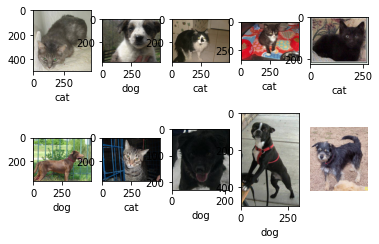

In [76]:
# Trying to print some random images from dataset
from PIL import Image
random_idx = np.random.randint(1, 25000, size = 10)
print(random_idx)

fig = plt.figure()
i = 1
for idx in random_idx:
    ax = fig.add_subplot(2, 5, i)
    animal = train_list[idx].split('.')[-3].split('/')[-1]
    ax.set_xlabel(animal)
    img = Image.open(train_list[idx])
    print(img.size, animal)
    plt.imshow(img)
    i += 1

plt.axis('off')
plt.show()

# We have varying image size
# Need to consider that too while doing image transformations

In [77]:
train_list[0].split('/')[-1].split('.')[0]

'dog'

In [78]:
int(test_list[0].split('/')[-1].split('.')[0])

10435

In [79]:
print(len(train_list), len(test_list))

25000 12500


In [80]:
# Splitting data --> training set, validation set, testing set(done)
from sklearn.model_selection import train_test_split
train_list, val_list = train_test_split(train_list, test_size = 0.2)

In [81]:
print(train_list[:5])
print(test_list[:5])

['../data/train/dog.2164.jpg', '../data/train/cat.2628.jpg', '../data/train/dog.3123.jpg', '../data/train/dog.5155.jpg', '../data/train/dog.8692.jpg']
['../data/test/10435.jpg', '../data/test/6790.jpg', '../data/test/4644.jpg', '../data/test/1835.jpg', '../data/test/1102.jpg']


In [82]:
print('Training samples : ', len(train_list))
print('Validation samples : ', len(val_list))
print('Testing samples : ', len(test_list))

Training samples :  20000
Validation samples :  5000
Testing samples :  12500


In [83]:
# Data augmentations and transformations

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

In [84]:
# Preparing datasets class
class dataset(Dataset):
    
    def __init__(self, file_list, transform = None):
        self.file_list = file_list
        self.transform = transform
    
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        # This is cat/dog in case of train or validation dataset
        # and it is image_idx in case of test dataset
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0
            
        return img_transformed, label

In [85]:
# Hyperparameters
batch_size = 100 # mini batch length
epochs = 10
lr = 0.001

In [86]:
# Individual datasets for each set
train_data = dataset(train_list, train_transforms)
test_data = dataset(test_list, test_transforms)
val_data = dataset(val_list, val_transforms)

In [87]:
# Individual dataloaders for each set
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(dataset = val_data, batch_size = batch_size, shuffle = True)

In [88]:
print(len(train_data), len(train_loader))
print(len(val_data), len(val_loader))
# batch_size = 100, each loader will contain 'batch_size' number of samples

20000 200
5000 50


In [89]:
train_data[0] # returns a tuple --> (image, label)

(tensor([[[0.4353, 0.4353, 0.4392,  ..., 0.4353, 0.4392, 0.4392],
          [0.4353, 0.4353, 0.4392,  ..., 0.4353, 0.4392, 0.4392],
          [0.4275, 0.4275, 0.4314,  ..., 0.4314, 0.4353, 0.4353],
          ...,
          [0.2510, 0.2510, 0.2588,  ..., 0.6627, 0.6706, 0.6706],
          [0.2392, 0.2392, 0.2471,  ..., 0.6627, 0.6667, 0.6667],
          [0.2392, 0.2392, 0.2471,  ..., 0.6627, 0.6667, 0.6667]],
 
         [[0.5176, 0.5176, 0.5216,  ..., 0.5529, 0.5569, 0.5569],
          [0.5176, 0.5176, 0.5216,  ..., 0.5529, 0.5569, 0.5569],
          [0.5137, 0.5137, 0.5176,  ..., 0.5490, 0.5529, 0.5529],
          ...,
          [0.3843, 0.3843, 0.3961,  ..., 0.4627, 0.4745, 0.4745],
          [0.3725, 0.3725, 0.3843,  ..., 0.4627, 0.4706, 0.4706],
          [0.3725, 0.3725, 0.3843,  ..., 0.4627, 0.4706, 0.4706]],
 
         [[0.4902, 0.4902, 0.4941,  ..., 0.4941, 0.4980, 0.4980],
          [0.4902, 0.4902, 0.4941,  ..., 0.4941, 0.4980, 0.4980],
          [0.4863, 0.4863, 0.4902,  ...,

In [90]:
print(train_data[0][0].shape, train_data[0][1])

torch.Size([3, 224, 224]) 1


In [91]:
print("train_loader checking :")
cnt = 5
for img, label in train_loader:
    print(img.shape, label.shape)
    cnt -= 1
    if cnt == 0:
        break
        
"""
For train_loader
Take an example to understand how DataLoader functions:
torch.Size([100, 3, 224, 224]) torch.Size([100])
FIRST:
100 = batch_size
3 = channels in image
224 x 224 = image dimensions
SECOND:
100 = batch_size
and each value = proper label of that corresponding image
"""

print("test_loader checking :")
cnt = 5
for img, label in test_loader:
    print(img.shape, len(label))
    cnt -= 1
    if cnt == 0:
        break

train_loader checking :
torch.Size([100, 3, 224, 224]) torch.Size([100])
torch.Size([100, 3, 224, 224]) torch.Size([100])
torch.Size([100, 3, 224, 224]) torch.Size([100])
torch.Size([100, 3, 224, 224]) torch.Size([100])
torch.Size([100, 3, 224, 224]) torch.Size([100])
test_loader checking :
torch.Size([100, 3, 224, 224]) 100
torch.Size([100, 3, 224, 224]) 100
torch.Size([100, 3, 224, 224]) 100
torch.Size([100, 3, 224, 224]) 100
torch.Size([100, 3, 224, 224]) 100


In [92]:
# Modelling part
# 3 Convolutional layers and 2 fully connected layers

class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size = 3, padding = 0, stride = 2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size = 3, padding = 0, stride = 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size = 3, padding = 0, stride = 2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # Add 2 dense layers
        # Find out dimensions of image first
        
        # image size after 3 convolutional layer = 3x3
        
        self.fc1 = nn.Linear(3*3*64, 10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10, 2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [93]:
model = CNN().to(device)
model.train()

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

In [94]:
# sample = next(iter(train_loader))
# print(sample[0].shape, sample[1].shape)
# sample = sample[0]
# print(sample.shape)
# out = model(sample)
# print(out.shape) # (100, 2) for each of 100 images, it will output 2 values
#                 #  0 -> probability of it being cat
#                 # 1 -> probability of it being dot

In [95]:
# Optimizers and loss functions
optimizer = optim.Adam(params = model.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()

In [96]:
# Training network now
print(device)
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    
    # For each epoch we are calculating training score as well as validation score

    for id, (data, label) in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
    
        output = model(data)
        loss = criterion(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
        
        if id % 10 == 0:
            print(f'Epoch: {epoch+1}, train accuracy: {epoch_accuracy} train loss: {epoch_loss}')
        
    print(f'Epoch: {epoch+1}, train accuracy: {epoch_accuracy} train loss: {epoch_loss}')
    
    # scoring trained model on validation set
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        
        for data, label in val_loader:
            data = data.to(device)
            label = label.to(device)
            
            val_output = model(data)
            val_loss = criterion(val_output, label)
            
            acc = (val_output.argmax(dim = 1) == label).float().mean()
            
            epoch_val_accuracy += acc / len(val_loader)
            epoch_val_loss += val_loss / len(val_loader)
            
        
        print(f'Epoch: {epoch + 1}, val_loss: {epoch_val_loss}, val_accuracy: {epoch_val_accuracy}')
    

cuda
Epoch: 1, train accuracy: 0.002649999689310789 train loss: 0.0034951157867908478
Epoch: 1, train accuracy: 0.031300000846385956 train loss: 0.03780897334218025
Epoch: 1, train accuracy: 0.058399997651576996 train loss: 0.07177656888961792
Epoch: 1, train accuracy: 0.0872499868273735 train loss: 0.10602764040231705
Epoch: 1, train accuracy: 0.11799997836351395 train loss: 0.13889741897583008
Epoch: 1, train accuracy: 0.1483999639749527 train loss: 0.17144624888896942
Epoch: 1, train accuracy: 0.17944994568824768 train loss: 0.20355841517448425
Epoch: 1, train accuracy: 0.21104994416236877 train loss: 0.23559243977069855
Epoch: 1, train accuracy: 0.24324995279312134 train loss: 0.2673540413379669
Epoch: 1, train accuracy: 0.27644991874694824 train loss: 0.29807811975479126
Epoch: 1, train accuracy: 0.30859991908073425 train loss: 0.32931479811668396
Epoch: 1, train accuracy: 0.340349942445755 train loss: 0.36144086718559265
Epoch: 1, train accuracy: 0.37384992837905884 train loss: 0

In [103]:
# PATH = './model.mdh'
# torch.save(model.state_dict(), PATH)
# my_model = CNN()
# my_model.load_state_dict(torch.load(PATH))
# print(my_model)

In [108]:
dog_probs = []
model.eval()

with torch.no_grad():
    for data, fileid in test_loader:
        data = data.to(device)
        preds = model(data)
        preds = F.softmax(preds, dim = 1)
        preds = preds[:, 1].tolist()
        dog_probs += list(zip(list(fileid), preds))

In [109]:
print(dog_probs[:5])

[('8319', 0.34164705872535706), ('5835', 0.18840956687927246), ('11481', 0.05613468214869499), ('1162', 0.48419666290283203), ('12289', 0.8617242574691772)]


In [111]:
dog_probs.sort(key = lambda x : int(x[0]))
dog_probs[:10]

[('1', 0.9233270287513733),
 ('2', 0.9785167574882507),
 ('3', 0.6246943473815918),
 ('4', 0.9641237258911133),
 ('5', 0.04706861078739166),
 ('6', 0.4017367959022522),
 ('7', 0.0029953750781714916),
 ('8', 0.09831749647855759),
 ('9', 0.1566649079322815),
 ('10', 0.049997568130493164)]

In [114]:
# Submission
ids = list(map(lambda x : x[0], dog_probs))
prob = list(map(lambda x : x[1], dog_probs))

print(ids[:5])
print(prob[:5])

['1', '2', '3', '4', '5']
[0.9233270287513733, 0.9785167574882507, 0.6246943473815918, 0.9641237258911133, 0.04706861078739166]


In [115]:
submission = pd.DataFrame({
    'id' : ids,
    'label' : prob
})

In [116]:
submission

,id,label
0,1,0.923327
1,2,0.978517
2,3,0.624694
3,4,0.964124
4,5,0.047069
...,...,...
12495,12496,0.038517
12496,12497,0.078422
12497,12498,0.404437
12498,12499,0.979309


In [117]:
submission.to_csv('result.csv', index = False)

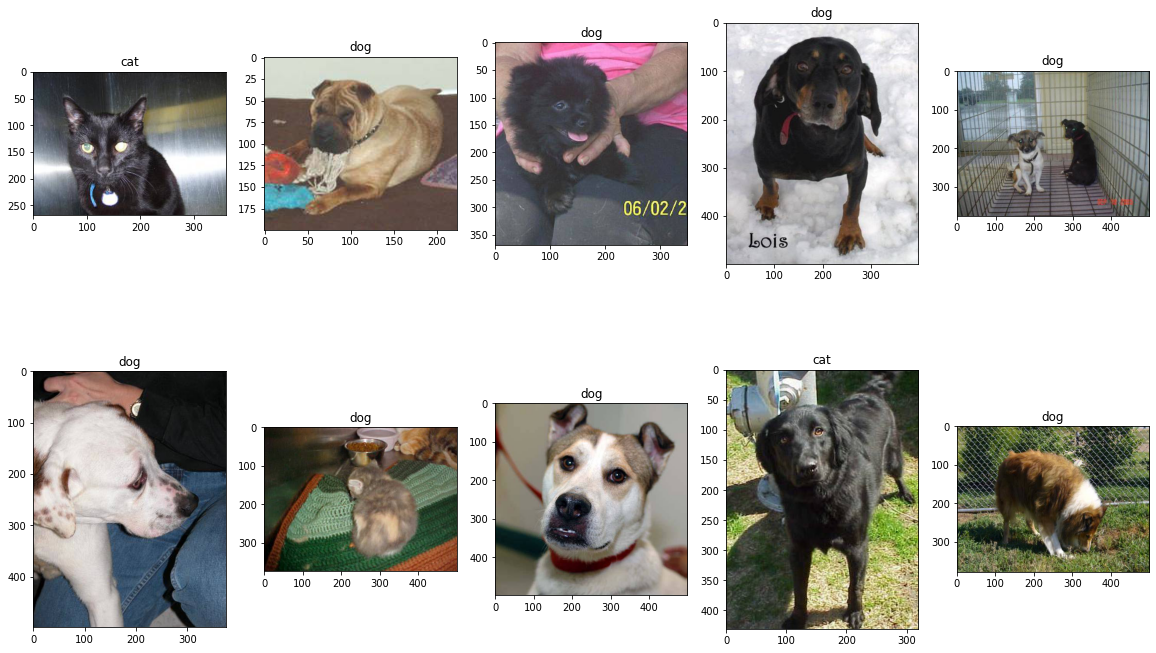

In [118]:
import random

id_list = []
class_ = {0: 'cat', 1: 'dog'}

fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():
    
    i = random.choice(submission['id'].values)
    
    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = os.path.join(test_dir, '{}.jpg'.format(i))
    img = Image.open(img_path)
    
    ax.set_title(class_[label])
    ax.imshow(img)